In [1]:
import pandas as pd
import geopandas as gpd
import re
from shapely.geometry import Point

file_path = '/Users/yujinlee/Google_Drive/NYU/Fall_2023/Capstone/CrimeData'
df_old = pd.read_csv(file_path + '/la_2010_to_2019.csv', low_memory = False)
df_new = pd.read_csv(file_path + '/la_2020_to_2023.csv', low_memory = False)

Crime data (2010-2019): https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
<br>Crime data (2020-2023): https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8

Zipcode geojson file: https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/ca_california_zip_codes_geo.min.json

In [2]:
df = pd.concat([df_old, df_new], ignore_index=True)

In [3]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,AREA
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13.0,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,NaN
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14.0,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,NaN
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13.0,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,NaN
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6.0,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,NaN
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1.0,Central,176,1,122,"RAPE, ATTEMPTED",...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,NaN


In [4]:
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace(' ', '_')

In [5]:
df.head()

,dr_no,date_rptd,date_occ,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,...,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,area
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13.0,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,NaN
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14.0,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,NaN
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13.0,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,NaN
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6.0,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,NaN
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1.0,Central,176,1,122,"RAPE, ATTEMPTED",...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,NaN


In [6]:
df['date_occ'] = df['date_occ'].str.slice(0, 10)
# Convert the 'occurred_on_date' column to datetime
df['date_occ'] = pd.to_datetime(df['date_occ'], format='%m/%d/%Y')

# Format the 'occurred_on_date' column to the desired format
df['date_occ'] = df['date_occ'].dt.strftime('%Y-%m-%d')

In [9]:
# Filtering dates
df['date_occ'] = pd.to_datetime(df['date_occ'])
threshold_date_from = pd.to_datetime('2018-01-01')
threshold_date_to = pd.to_datetime('2023-05-31')
df = df[threshold_date_to >= df['date_occ']]
df = df[threshold_date_from <= df['date_occ']]

In [10]:
df.to_csv(file_path + '/la_combined_modified.csv', index=False)

In [11]:
df.head()

,dr_no,date_rptd,date_occ,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,...,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,area
802737,212016382,11/01/2021 12:00:00 AM,2021-10-31,2300,20.0,Olympic,2029,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,3100 GENEVA ST,NaN,34.0677,-118.2850,NaN
802850,221904002,01/01/2022 12:00:00 AM,2021-12-31,1600,19.0,Mission,1987,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,8700 SYLMAR AV,NaN,34.2282,-118.4445,NaN
802906,221312198,06/02/2022 12:00:00 AM,2021-08-31,1200,13.0,Newton,1351,1,510,VEHICLE - STOLEN,...,Invest Cont,510.0,NaN,NaN,NaN,VERNON,GRAND,34.0038,-118.2805,NaN
803605,211612176,10/05/2021 12:00:00 AM,2021-10-04,2030,16.0,Foothill,1612,1,330,BURGLARY FROM VEHICLE,...,Invest Cont,330.0,NaN,NaN,NaN,PAXTON,BRADLEY,34.2749,-118.4246,NaN
804822,230606221,02/22/2023 12:00:00 AM,2021-09-11,1500,6.0,Hollywood,669,1,440,THEFT PLAIN - PETTY ($950 & UNDER),...,Invest Cont,440.0,NaN,NaN,NaN,1100 N KINGSLEY DR,NaN,34.0908,-118.3025,NaN


In [12]:
df['lat'].isnull().mean()

0.0

In [13]:
df['lon'].isnull().mean()

0.0

In [14]:
df['location'] = df.apply(lambda row: f"({row['lat']}, {row['lon']})", axis=1)

In [15]:
file_path_geo = '/Users/yujinlee/Google_Drive/NYU/Fall_2023/Capstone/CrimeData/ZIP_Codes.geojson'

zipcode = gpd.read_file(file_path_geo)
zipcode.head()

,OBJECTID,ZIP5,ShapeSTArea,ShapeSTLength,geometry
0,1,02134,3.721936e+07,40794.182396,"POLYGON ((-71.12340 42.36421, -71.12345 42.364..."
1,2,02125,6.476052e+07,62224.521440,"POLYGON ((-71.04541 42.32381, -71.04579 42.323..."
2,3,02110,6.637284e+06,18358.213496,"POLYGON ((-71.05109 42.36418, -71.05109 42.364..."
3,4,02118,3.116158e+07,32353.407618,"POLYGON ((-71.06315 42.34689, -71.06433 42.347..."
4,5,02126,6.078585e+07,45488.394711,"POLYGON ((-71.09670 42.29095, -71.09692 42.290..."


In [16]:
file_path_geo = '/Users/yujinlee/Google_Drive/NYU/Fall_2023/Capstone/CrimeData/ca_california_zip_codes_geo.min.json'

zipcode = gpd.read_file(file_path_geo)
zipcode.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,06,94601,0694601,B5,G6350,S,8410939,310703,+37.7755447,-122.2187049,N,"POLYGON ((-122.22717 37.79197, -122.22693 37.7..."
1,06,94501,0694501,B5,G6350,S,20539466,9005303,+37.7737968,-122.2781230,N,"POLYGON ((-122.29181 37.76301, -122.30661 37.7..."
2,06,94560,0694560,B5,G6350,S,35757865,60530,+37.5041413,-122.0323587,N,"POLYGON ((-122.05499 37.54959, -122.05441 37.5..."
3,06,94587,0694587,B5,G6350,S,51075108,0,+37.6031556,-122.0186382,N,"POLYGON ((-122.06515 37.60485, -122.06499 37.6..."
4,06,94580,0694580,B5,G6350,S,8929836,17052,+37.6757312,-122.1330170,N,"POLYGON ((-122.12999 37.68445, -122.12995 37.6..."


In [17]:
def create_point_from_string(coord_str):
    match = re.match(r'\(([^,]+), ([^)]+)\)', coord_str)
    if match:
        lat, lon = map(float, match.groups())
        return Point(lon, lat)
    return None

In [18]:
df['geometry'] = df['location'].apply(create_point_from_string)

In [19]:
df.head()

,dr_no,date_rptd,date_occ,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,...,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,area,geometry
802737,212016382,11/01/2021 12:00:00 AM,2021-10-31,2300,20.0,Olympic,2029,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.0677, -118.285)",NaN,34.0677,-118.2850,NaN,POINT (-118.285 34.0677)
802850,221904002,01/01/2022 12:00:00 AM,2021-12-31,1600,19.0,Mission,1987,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.2282, -118.4445)",NaN,34.2282,-118.4445,NaN,POINT (-118.4445 34.2282)
802906,221312198,06/02/2022 12:00:00 AM,2021-08-31,1200,13.0,Newton,1351,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.0038, -118.2805)",GRAND,34.0038,-118.2805,NaN,POINT (-118.2805 34.0038)
803605,211612176,10/05/2021 12:00:00 AM,2021-10-04,2030,16.0,Foothill,1612,1,330,BURGLARY FROM VEHICLE,...,330.0,NaN,NaN,NaN,"(34.2749, -118.4246)",BRADLEY,34.2749,-118.4246,NaN,POINT (-118.4246 34.2749)
804822,230606221,02/22/2023 12:00:00 AM,2021-09-11,1500,6.0,Hollywood,669,1,440,THEFT PLAIN - PETTY ($950 & UNDER),...,440.0,NaN,NaN,NaN,"(34.0908, -118.3025)",NaN,34.0908,-118.3025,NaN,POINT (-118.3025 34.0908)


In [20]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.head()

,dr_no,date_rptd,date_occ,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,...,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,area,geometry
802737,212016382,11/01/2021 12:00:00 AM,2021-10-31,2300,20.0,Olympic,2029,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.0677, -118.285)",NaN,34.0677,-118.2850,NaN,POINT (-118.28500 34.06770)
802850,221904002,01/01/2022 12:00:00 AM,2021-12-31,1600,19.0,Mission,1987,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.2282, -118.4445)",NaN,34.2282,-118.4445,NaN,POINT (-118.44450 34.22820)
802906,221312198,06/02/2022 12:00:00 AM,2021-08-31,1200,13.0,Newton,1351,1,510,VEHICLE - STOLEN,...,510.0,NaN,NaN,NaN,"(34.0038, -118.2805)",GRAND,34.0038,-118.2805,NaN,POINT (-118.28050 34.00380)
803605,211612176,10/05/2021 12:00:00 AM,2021-10-04,2030,16.0,Foothill,1612,1,330,BURGLARY FROM VEHICLE,...,330.0,NaN,NaN,NaN,"(34.2749, -118.4246)",BRADLEY,34.2749,-118.4246,NaN,POINT (-118.42460 34.27490)
804822,230606221,02/22/2023 12:00:00 AM,2021-09-11,1500,6.0,Hollywood,669,1,440,THEFT PLAIN - PETTY ($950 & UNDER),...,440.0,NaN,NaN,NaN,"(34.0908, -118.3025)",NaN,34.0908,-118.3025,NaN,POINT (-118.30250 34.09080)


In [21]:
gdf.set_crs(epsg=4326, inplace=True)
zipcode.set_crs(epsg=4326, inplace=True)
result = gpd.sjoin(gdf, zipcode, how="left", op='within')

/Users/yujinlee/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [22]:
result.head()

,dr_no,date_rptd,date_occ,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,...,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
802737,212016382,11/01/2021 12:00:00 AM,2021-10-31,2300,20.0,Olympic,2029,1,510,VEHICLE - STOLEN,...,90020,0690020,B5,G6350,S,2927480.0,0.0,+34.0663795,-118.3098700,N
802850,221904002,01/01/2022 12:00:00 AM,2021-12-31,1600,19.0,Mission,1987,1,510,VEHICLE - STOLEN,...,91402,0691402,B5,G6350,S,9652884.0,77471.0,+34.2225061,-118.4446893,N
802906,221312198,06/02/2022 12:00:00 AM,2021-08-31,1200,13.0,Newton,1351,1,510,VEHICLE - STOLEN,...,90037,0690037,B5,G6350,S,7351184.0,0.0,+34.0027226,-118.2874866,N
803605,211612176,10/05/2021 12:00:00 AM,2021-10-04,2030,16.0,Foothill,1612,1,330,BURGLARY FROM VEHICLE,...,91331,0691331,B5,G6350,S,22928415.0,120343.0,+34.2554415,-118.4213135,N
804822,230606221,02/22/2023 12:00:00 AM,2021-09-11,1500,6.0,Hollywood,669,1,440,THEFT PLAIN - PETTY ($950 & UNDER),...,90029,0690029,B5,G6350,S,3526895.0,0.0,+34.0898482,-118.2946605,N


In [23]:
result.set_index('date_occ', inplace=True)

In [24]:
result.index = pd.to_datetime(result.index)
result.head()

,dr_no,date_rptd,time_occ,area_,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,...,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
date_occ,,,,,,,,,,,,,,,,,,,,,
2021-10-31,212016382,11/01/2021 12:00:00 AM,2300,20.0,Olympic,2029,1,510,VEHICLE - STOLEN,NaN,...,90020,0690020,B5,G6350,S,2927480.0,0.0,+34.0663795,-118.3098700,N
2021-12-31,221904002,01/01/2022 12:00:00 AM,1600,19.0,Mission,1987,1,510,VEHICLE - STOLEN,NaN,...,91402,0691402,B5,G6350,S,9652884.0,77471.0,+34.2225061,-118.4446893,N
2021-08-31,221312198,06/02/2022 12:00:00 AM,1200,13.0,Newton,1351,1,510,VEHICLE - STOLEN,NaN,...,90037,0690037,B5,G6350,S,7351184.0,0.0,+34.0027226,-118.2874866,N
2021-10-04,211612176,10/05/2021 12:00:00 AM,2030,16.0,Foothill,1612,1,330,BURGLARY FROM VEHICLE,0344,...,91331,0691331,B5,G6350,S,22928415.0,120343.0,+34.2554415,-118.4213135,N
2021-09-11,230606221,02/22/2023 12:00:00 AM,1500,6.0,Hollywood,669,1,440,THEFT PLAIN - PETTY ($950 & UNDER),1822 0344,...,90029,0690029,B5,G6350,S,3526895.0,0.0,+34.0898482,-118.2946605,N


In [25]:
weekly_data = result.groupby('ZCTA5CE10').resample('W').size().reset_index(name='total_count')

In [26]:
weekly_data['ZCTA5CE10'].unique().shape

(151,)

In [27]:
weekly_data

,ZCTA5CE10,date_occ,total_count
0,90001,2018-01-07,21
1,90001,2018-01-14,14
2,90001,2018-01-21,17
3,90001,2018-01-28,16
4,90001,2018-02-04,23
...,...,...,...
40084,91801,2021-04-18,0
40085,91801,2021-04-25,0
40086,91801,2021-05-02,0
40087,91801,2021-05-09,1


In [28]:
mean_counts_by_zip = weekly_data.groupby('ZCTA5CE10')['total_count'].mean().reset_index()
mean_counts_by_zip

,ZCTA5CE10,total_count
0,90001,17.215548
1,90002,54.212014
2,90003,115.858657
3,90004,73.611307
4,90005,50.388693
...,...,...
146,91606,38.424028
147,91607,23.819788
148,91608,0.627660
149,91801,0.086207


In [29]:
weekly_data.to_csv(file_path + '/LA_weekly_data.csv', index=False)

### Run from here!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
file_path = '/Users/yujinlee/Google_Drive/NYU/Fall_2023/Capstone/CrimeData'
weekly_data = pd.read_csv(file_path + '/LA_weekly_data.csv', low_memory = False)


In [2]:
weekly_data.head()

,ZCTA5CE10,date_occ,total_count
0,90001,2018-01-07,21
1,90001,2018-01-14,14
2,90001,2018-01-21,17
3,90001,2018-01-28,16
4,90001,2018-02-04,23


In [3]:
pop = pd.read_csv(file_path + '/la_2022_acs.csv', low_memory = False)
pop.head()

,Label (Grouping),ZCTA5 90001!!Estimate,ZCTA5 90002!!Estimate,ZCTA5 90003!!Estimate,ZCTA5 90004!!Estimate,ZCTA5 90005!!Estimate,ZCTA5 90006!!Estimate,ZCTA5 90007!!Estimate,ZCTA5 90008!!Estimate,ZCTA5 90010!!Estimate,...,ZCTA5 91504!!Estimate,ZCTA5 91505!!Estimate,ZCTA5 91506!!Estimate,ZCTA5 91601!!Estimate,ZCTA5 91602!!Estimate,ZCTA5 91604!!Estimate,ZCTA5 91605!!Estimate,ZCTA5 91606!!Estimate,ZCTA5 91607!!Estimate,ZCTA5 91608!!Estimate
0,SEX AND AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total population,"57,652","53,108","75,024","58,833","37,754","56,628","41,004","33,076","4,185",...,"27,479","32,156","19,559","35,615","19,980","32,073","51,654","43,552","30,734",56
2,Male,"29,102","26,040","37,793","29,865","19,019","27,655","20,881","15,581","2,174",...,"13,334","15,821","9,785","17,264","9,878","16,384","25,521","22,017","14,515",36
3,Female,"28,550","27,068","37,231","28,968","18,735","28,973","20,123","17,495","2,011",...,"14,145","16,335","9,774","18,351","10,102","15,689","26,133","21,535","16,219",20
4,Sex ratio (males per 100 females),101.9,96.2,101.5,103.1,101.5,95.5,103.8,89.1,108.1,...,94.3,96.9,100.1,94.1,97.8,104.4,97.7,102.2,89.5,180.0


In [4]:
pop_transposed = pop.transpose()
pop_transposed = pop_transposed.reset_index()
new_header = pop_transposed.iloc[0]  
pop_transposed = pop_transposed[1:]  
pop_transposed.columns = new_header  # Set the header row as the df header

In [5]:
pop_transposed.head()

,Label (Grouping),SEX AND AGE,Total population,Male,Female,Sex ratio (males per 100 females),Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,...,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Two or More Races,Two races including Some Other Race,"Two races excluding Some Other Race, and three or more races",Total housing units,"CITIZEN, VOTING AGE POPULATION","Citizen, 18 and over population",Male,Female
1,ZCTA5 90001!!Estimate,NaN,"57,652","29,102","28,550",101.9,"4,145","4,620","5,120","4,820",...,13,60,253,20,233,"14,157",NaN,"25,411","12,748","12,663"
2,ZCTA5 90002!!Estimate,NaN,"53,108","26,040","27,068",96.2,"3,519","4,341","4,687","4,533",...,21,89,335,102,233,"13,639",NaN,"25,979","11,970","14,009"
3,ZCTA5 90003!!Estimate,NaN,"75,024","37,793","37,231",101.5,"5,689","6,484","7,206","6,378",...,0,574,416,246,170,"18,703",NaN,"31,241","14,230","17,011"
4,ZCTA5 90004!!Estimate,NaN,"58,833","29,865","28,968",103.1,"3,221","3,287","2,932","2,533",...,68,280,"2,027",331,"1,696","25,617",NaN,"33,010","16,704","16,306"
5,ZCTA5 90005!!Estimate,NaN,"37,754","19,019","18,735",101.5,"1,726","1,786","2,058","1,669",...,14,43,"1,042",70,972,"18,650",NaN,"18,465","8,798","9,667"


In [6]:
print(pop_transposed.columns)

Index(['Label (Grouping)', 'SEX AND AGE', '    Total population',
       '        Male', '        Female',
       '        Sex ratio (males per 100 females)', '        Under 5 years',
       '        5 to 9 years', '        10 to 14 years',
       '        15 to 19 years', '        20 to 24 years',
       '        25 to 34 years', '        35 to 44 years',
       '        45 to 54 years', '        55 to 59 years',
       '        60 to 64 years', '        65 to 74 years',
       '        75 to 84 years', '        85 years and over',
       '        Median age (years)', '        Under 18 years',
       '        16 years and over', '        18 years and over',
       '        21 years and over', '        62 years and over',
       '        65 years and over', '        18 years and over',
       '            Male', '            Female',
       '            Sex ratio (males per 100 females)',
       '        65 years and over', '            Male', '            Female',
       '            

In [7]:
df = pop_transposed
df.columns = df.columns.str.strip()

if 'level_0' in df.columns:
    df.drop('level_0', axis=1, inplace=True)
df.reset_index(inplace=True)

df_estimates = df[df['Label (Grouping)'].str.contains('!!Estimate')]
df_estimates = df_estimates[['Label (Grouping)', 'Total population']]
df_estimates.set_index(df_estimates['Label (Grouping)'].str.replace('!!Estimate', ''), inplace=True)
df_estimates.drop('Label (Grouping)', axis=1, inplace=True)
pop = df_estimates.reset_index(drop=False)
pop.head()

,Label (Grouping),Total population,Total population,Total population,Total population
0,ZCTA5 90001,"57,652","57,652","57,652","57,652"
1,ZCTA5 90002,"53,108","53,108","53,108","53,108"
2,ZCTA5 90003,"75,024","75,024","75,024","75,024"
3,ZCTA5 90004,"58,833","58,833","58,833","58,833"
4,ZCTA5 90005,"37,754","37,754","37,754","37,754"


In [8]:
pop = pop.rename(columns={"Label (Grouping)": "ZCTA5CE10"})
pop['ZCTA5CE10'] = pop['ZCTA5CE10'].str.replace('ZCTA5 ', '')
pop = pop.iloc[:, [0, 1]]  # Keeps only the first two columns
pop.head()

,ZCTA5CE10,Total population
0,90001,"57,652"
1,90002,"53,108"
2,90003,"75,024"
3,90004,"58,833"
4,90005,"37,754"


In [10]:
weekly_data['ZCTA5CE10'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 40089 entries, 0 to 40088
Series name: ZCTA5CE10
Non-Null Count  Dtype
--------------  -----
40089 non-null  int64
dtypes: int64(1)
memory usage: 313.3 KB


In [11]:
weekly_data['ZCTA5CE10'] = weekly_data['ZCTA5CE10'].astype(str).str.zfill(5)

In [45]:
merged_df = pd.merge(weekly_data, pop, on='ZCTA5CE10', how='left')
merged_df.head()

,ZCTA5CE10,date_occ,total_count,Total population
0,90001,2018-01-07,21,"57,652"
1,90001,2018-01-14,14,"57,652"
2,90001,2018-01-21,17,"57,652"
3,90001,2018-01-28,16,"57,652"
4,90001,2018-02-04,23,"57,652"


In [46]:
merged_df.head()

,ZCTA5CE10,date_occ,total_count,Total population
0,90001,2018-01-07,21,"57,652"
1,90001,2018-01-14,14,"57,652"
2,90001,2018-01-21,17,"57,652"
3,90001,2018-01-28,16,"57,652"
4,90001,2018-02-04,23,"57,652"


In [47]:
merged_df['Total population'] = pd.to_numeric(merged_df['Total population'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)
merged_df['crime_rate'] = (merged_df['total_count'] / merged_df['Total population']) * 10000
merged_df = merged_df.rename(columns={'date_occ': 'week'})
merged_df = merged_df.rename(columns={'Total population': "total_population"})
merged_df['week'] = pd.to_datetime(merged_df['week'])

In [48]:
merged_df.head()

,ZCTA5CE10,week,total_count,total_population,crime_rate
0,90001,2018-01-07,21,57652,3.642545
1,90001,2018-01-14,14,57652,2.428363
2,90001,2018-01-21,17,57652,2.948727
3,90001,2018-01-28,16,57652,2.775272
4,90001,2018-02-04,23,57652,3.989454


In [49]:
merged_df.shape

(40089, 5)

In [50]:
merged_df[merged_df['total_population'] != 0]['ZCTA5CE10'].unique()

In [51]:
merged_df.shape

(37082, 5)

In [52]:
merged_df.to_csv(file_path + 'la_weekly_data_rate.csv', index=False)

In [4]:
print(file_path + '/la_weekly_data_rate.csv')

/Users/yujinlee/Google_Drive/NYU/Fall_2023/Capstone/CrimeDatala_weekly_data_rate.csv


In [53]:
df_plot = merged_df

In [54]:
df_plot.set_index('week', inplace=True)

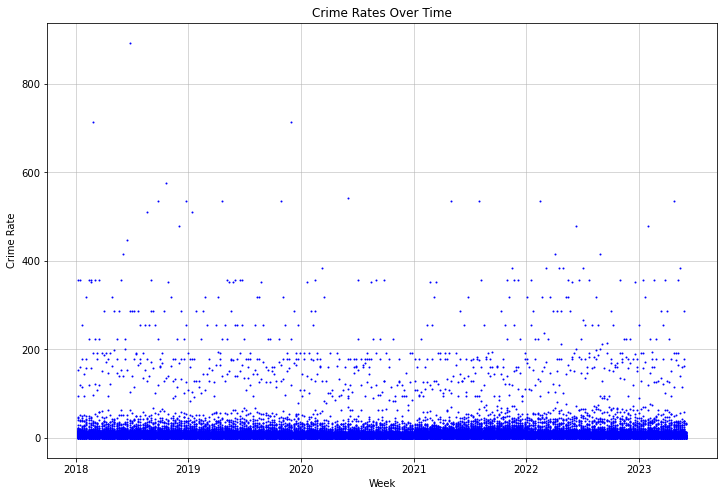

In [55]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

In [56]:
merged_df['crime_rate'].median()

8.518217369419599

In [60]:
# total_count total_population
merged_df['total_count'].sum()/merged_df.groupby('ZCTA5CE10')['total_population'].first().sum()


0.2549142713190649

In [20]:
import pandas as pd

file_path = '/Users/yujinlee/Google_Drive/NYU/Fall_2023/Capstone/CrimeData'

merged_df = pd.read_csv(file_path + '/la_weekly_data_rate.csv')

In [21]:
merged_df.head()

,ZCTA5CE10,week,total_count,total_population,crime_rate
0,90001,2018-01-07,21,57652,3.642545
1,90001,2018-01-14,14,57652,2.428363
2,90001,2018-01-21,17,57652,2.948727
3,90001,2018-01-28,16,57652,2.775272
4,90001,2018-02-04,23,57652,3.989454


In [22]:
statistics = merged_df.describe().T

# Display the descriptive statistics
print(statistics)

                    count          mean           std      min           25%  \
ZCTA5CE10         37082.0  90548.780163    605.515287  90001.0  90036.000000   
total_count       37082.0     33.428024     28.428876      0.0      9.000000   
total_population  37082.0  36313.848579  20743.294169     56.0  23689.000000   
crime_rate        37082.0     12.731668     29.203271      0.0      4.424942   

                           50%           75%            max  
ZCTA5CE10         90230.000000  91316.000000   91608.000000  
total_count          30.000000     50.000000     189.000000  
total_population  33076.000000  47682.000000  106042.000000  
crime_rate            8.518217     12.213055     892.857143  


In [23]:
merged_df['ZCTA5CE10'].nunique()

135

In [24]:
print(merged_df['total_count'].median())
print(merged_df['total_population'].median())
print(merged_df['crime_rate'].median())

30.0
33076.0
8.518217369419599


In [25]:
merged_df['week'] = pd.to_datetime(merged_df['week'])

In [26]:
df_plot = merged_df

In [27]:
df_plot.set_index('week', inplace=True)

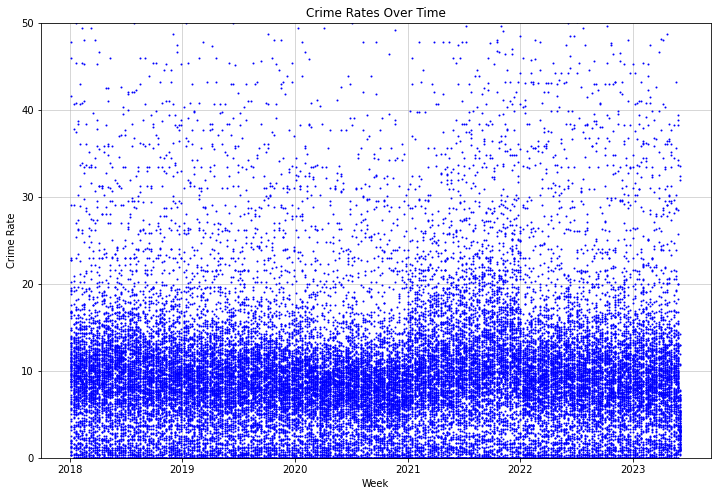

In [29]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.ylim(0, 50)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

In [43]:
df_plot_temp = df_plot.reset_index()

In [48]:
df_plot_temp

,week,ZCTA5CE10,total_count,total_population,crime_rate
0,2018-01-07,98101,126,16302,77.291130
5943,2018-01-07,98144,62,32540,19.053473
5094,2018-01-07,98126,32,21102,15.164439
4811,2018-01-07,98125,88,43993,20.003182
4528,2018-01-07,98122,102,41268,24.716487
...,...,...,...,...,...
1131,2023-06-04,98104,26,15052,17.273452
848,2023-06-04,98103,15,51878,2.891399
565,2023-06-04,98102,15,25827,5.807875
3678,2023-06-04,98117,13,36115,3.599612


In [49]:
df_plot_temp = df_plot_temp.sort_values(by='week').reset_index()

In [57]:
min_date = df_plot_temp['week'].min()
df_plot_temp['week_no'] = ((df_plot_temp['week'] - min_date).dt.days // 7) + 1

In [58]:
df_plot_temp

,index,week,ZCTA5CE10,total_count,total_population,crime_rate,week_no
0,0,2018-01-07,98101,126,16302,77.291130,1
1,1132,2018-01-07,98105,98,50302,19.482327,1
2,5660,2018-01-07,98136,15,17420,8.610792,1
3,5377,2018-01-07,98133,69,50921,13.550402,1
4,1415,2018-01-07,98106,45,28243,15.933152,1
...,...,...,...,...,...,...,...
7768,5942,2023-06-04,98136,2,17420,1.148106,283
7769,6225,2023-06-04,98144,32,32540,9.834050,283
7770,3678,2023-06-04,98117,13,36115,3.599612,283
7771,3112,2023-06-04,98115,21,54457,3.856254,283


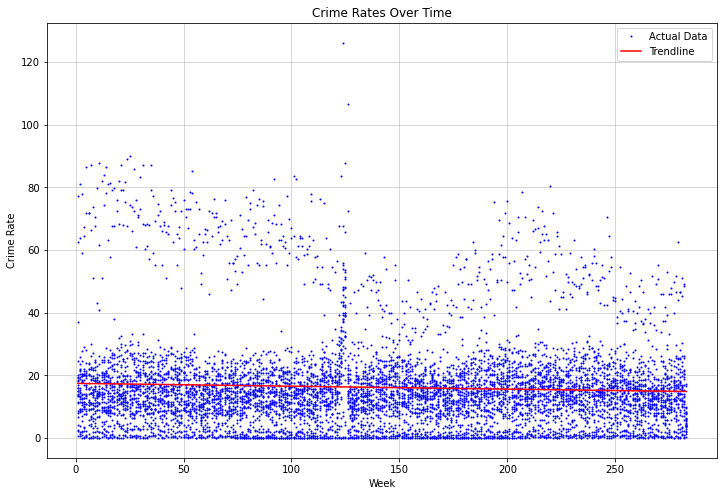

In [59]:
x = np.arange(len(df_plot_temp['week_no'])).reshape(-1, 1)
y = df_plot_temp['crime_rate']

# Fit linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(df_plot_temp['week_no'], y, marker='o', linestyle='None', color='b', markersize=1, label='Actual Data')
plt.plot(df_plot_temp['week_no'], y_pred, color='r', label='Trendline')

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.legend()
plt.show()